Use GPU if available

In [117]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )

print(f"Using {device} device")

Using cuda device


Load CIFAR10 dataset

In [118]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()]
    )

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, # reshuffle data at every epoch
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
    )

classes = ("plane", "car", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


Define the neural network

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, stride=1, padding=2)
        self.batchNorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.batchNorm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.batchNorm3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.batchNorm4 = nn.BatchNorm1d(500)

        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv2(x)
        x = self.batchNorm2(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv3(x)
        x = self.batchNorm3(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.fc1(x)
        x = self.batchNorm4(x) # batch normalization
        x = F.relu(x)

        x = F.dropout(x, p=0.5)
        x = self.fc2(x)

        return x


Define optimizer

In [120]:
import torch.optim as optim
import torch.nn as nn

torch.manual_seed(1)
model = Net()
model.to(device)

lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.0) # mini batch gradient descent

Train the neural network

Epochs: 15
Batch size: 32
Learning rate: 0.01
epoch: 0, total loss: 2114.4854140281677
epoch: 1, total loss: 1585.0745528638363
epoch: 2, total loss: 1362.6469706594944
epoch: 3, total loss: 1233.971689850092
epoch: 4, total loss: 1115.0759784579277
epoch: 5, total loss: 1019.733223348856
epoch: 6, total loss: 932.7230337113142
epoch: 7, total loss: 861.1559426486492
epoch: 8, total loss: 785.6879176646471
epoch: 9, total loss: 730.2365639060736
epoch: 10, total loss: 672.0067768618464
epoch: 11, total loss: 628.0756278038025
epoch: 12, total loss: 563.163843087852
epoch: 13, total loss: 516.2096603959799
epoch: 14, total loss: 469.9514710716903
Finished training, time taken 285.0717427259997 seconds


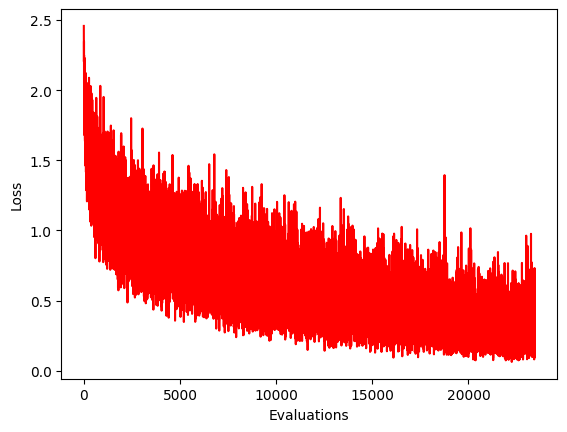

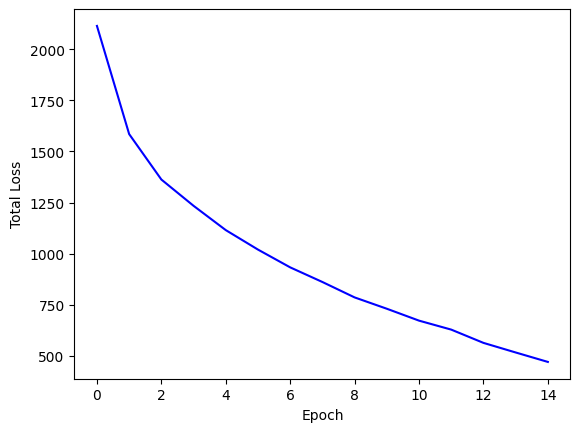

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import time

total_loss_list = []
loss_list = []
epochs = 15
start = time.perf_counter()

print("Epochs: " + str(epochs))
print("Batch size: " + str(batch_size))
print("Learning rate: " + str(lr))

for epoch in range(epochs):  # loop over the dataset multiple times

  total_loss = 0

  # on each mini-batch, the model uses the same weigths for that current
  # mini-batch, hence, the number of times the model weights will be updated
  # is given by total_trainset / mini_batch_size

  # loop over the dataset and get mini-batch
  for mini_batch_num, data in enumerate(trainloader, 0):
    images = data[0].to(device)
    labels = data[1].to(device)

    optimizer.zero_grad() # zero the parameter gradients

    preds = model(images) # forward mini-batch
    loss = F.cross_entropy(preds, labels) # calculate loss of all the mini-batch

    loss_list.append(loss.item()) # track the loss

    loss.backward() # calculate gradients with respect to each weight
    optimizer.step() # update weights

    total_loss += loss.item()

  print(f"epoch: {epoch}, total loss: {total_loss}")
  total_loss_list.append(total_loss)

end = time.perf_counter()

print(f"Finished training, time taken {end-start} seconds")

# plot the loss rate
plt.plot(np.array(loss_list), 'r')
plt.ylabel("Loss")
plt.xlabel("Evaluations")
plt.show()
plt.plot(np.array(total_loss_list), 'b')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.show()

Test the neural network

In [136]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 74 %


Save the model

In [123]:
PATH = "./cifar10_model.pth"
# torch.save(model.state_dict(), PATH)

Load the model

In [135]:
model = Net()
model.load_state_dict(torch.load(PATH))

model.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (batchNorm4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

Freeze all the weights except for the last layer

In [137]:
# Freeze all the parameters in the network
for param in model.parameters():
  param.requires_grad = False

# Unfreeze all the parameters from the last layer and randomize the weights
for param in model.fc2.parameters():
  param.requires_grad = True
  param.data = torch.rand(param.size())

model.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (batchNorm4): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [139]:
import operator
import random
import numpy
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

# all the parameters from the last layer will be the decision variables
# the fitness will be the loss function, i.e. cross entropy

DIMENSIONS = len(model.fc2.parameters())
GENERATIONS = 100

POPULATIONS_SIZE = 50
C1 = 2.0
C2 = 2.0

max_weight = 0.9
min_weight = 0.4
init_min_position = -1 # minimum decision variable value
init_max_position = 1 # maximum decision variable value
init_min_velocity = 0.5 # minimum velocity a particle can have at initilisation
init_max_velocity = 1.5 # maximum velocity a particle can have at initilisation

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle",
               list, # current solution (i.e. NN parameters)
               fitness=creator.FitnessMin, # current fitness
               velocity=list, # current velocity (different velocity per decision variable / NN parameter)
               min_velocity=None, # velocity clamping values
               max_velocity=None, # velocity clamping values
               personal_best=None
               )

def generate_particle(dimensions, min_velocity, max_velocity):
  # set the intial solution (NN parameters)
  particle = creator.Particle(random.uniform(init_min_position, init_max_position) for _ in range(dimensions))

  # set the initial velocity
  particle.velocity = [random.uniform(init_min_velocity, init_max_velocity)]

  # velocity clamping
  particle.min_velocity = min_velocity
  particle.max_velocity = max_velocity

def objective_function():
  return nn.
# create a population of random particles
population = []
for _ in range(POPULATIONS_SIZE):
  population.append(generate_particle(dimensions=DIMENSIONS))

for g in range(GENERATIONS):
  # decaying inertia weight
  weight = max_weight - (max_weight - min_weight) * g / GENERATIONS

  for particle in population:
    # evaluate fitness value
    particle.fitness.values =

    # check if the fitness value is better than personal best

# set the best of the personal best as the global best

## update the particles velocity -> v(t+1) =
# w*v(t)
# + c1*r1(t) (pbest - x(t))
# + c2*r2(t) (gbest - x(t))

# w -> inertia decaying weight
# c1 and c2 -> constants
# r1(t) and r2(t) -> uniformly distributed random number between [0,1]
#                    each time instant, for each particle, and for each
#                    dimension
# pbest -> personal best solution of the current particle (n-dimensional vector)
# gbest -> global best solution (n-dimensional vector)
# n -> number of decision variables (parameters)

## update the particles positions (parameters)


SyntaxError: ignored